In [1]:
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact
import ipywidgets as widgets

# Reward shaping for path-following like

We have two measures: XTE (cross-track error) and VMC (velocity made good to course).

## Let's start with XTE
We want to allow the agent to be in certain range around the path. Let $\delta$ be the allowed XTE threshold such that if $|XTE| < \delta$ then the agent is considered to be on the path. We want to penalize the agent for being off the path.


$$
r(XTE) = \begin{cases}
    1 & \text{if } |XTE| \le \delta \\
    -1 & \text{otherwise}
\end{cases}
$$

In [2]:
xte = np.linspace(0, 4, 1000)

In [3]:
def plot_01(delta):
    r = 2*(xte < delta)-1
    plt.plot(xte, r);

interact(plot_01,
        delta=widgets.FloatSlider(min=0, max=3, value=1));

interactive(children=(FloatSlider(value=1.0, description='delta', max=3.0), Output()), _dom_classes=('widget-i…

However, this reward function is considered as a sparse reward function, which is not good for learning. We want to use a smooth reward function instead. One simple approach would be to use an affine function that decrease linearly from $1$ to $-1$ when $|XTE|$ increase.

$$
r(XTE) = max\left(-1, -\frac{\lvert XTE \rvert - \delta}{\delta}\right)
$$

In [4]:

def plot_lin(delta):
    r = np.maximum(-1, -(xte-delta)/delta)
    plt.plot(xte, r);

interact(plot_lin,
        delta=widgets.FloatSlider(min=0, max=3, value=1));

interactive(children=(FloatSlider(value=1.0, description='delta', max=3.0), Output()), _dom_classes=('widget-i…

One other solution would be to use a sigmoid-like function that allow us more control over the shape of the reward function:

$$
\tilde{\sigma}(x) := 2\sigma(x) - 1
$$
where $\sigma(x) := \frac{1}{1+e^{-x}}$.

Remark that $\tilde{\sigma}(x) = -\tilde\sigma(-x)$:

$$
\begin{align*}
\tilde{\sigma}(x) &= 2\sigma(x) - 1 = \frac{1 - e^{-x}}{1+e^{-x}} = \frac{e^{x} - 1}{e^{x}+1} = -2\sigma(-x) + 1 = -\tilde\sigma(-x)
\end{align*}
$$

Using this function, we get the following reward function:

$$
r(XTE) = \tilde\sigma\left(-\alpha (|XTE| - \delta)\right)
$$

Which have the following properties:
- $r(\delta) = 0$: the agent is at the edge of the path and is not penalized nor rewarded.
- $r$ is monotonically decreasing: the further the agent is from the path, the more it is penalized.
- $r : \mathbb{R} \to [-1,1]$: the reward is bounded between $-1$ and $1$.
- $r$ is smooth: the reward is smooth and differentiable.

We want to set $\alpha$ such that the reward function smoothly transition from reward to penalty in a small range around $\delta$, i.e. from $\delta - \epsilon$ to $\delta + \epsilon$. Moreover, let $\eta \in (0,2)$ be the amount of reward that we want to use during the transition. We want to find $\alpha$ such that:

$$
\begin{align*}
&&\lvert r(\delta - \epsilon) - r(\delta + \epsilon) \rvert &= \eta \\
\iff &&\tilde\sigma(\alpha\epsilon) - \tilde\sigma(-\alpha\epsilon) &= \eta \\
\iff &&2\tilde\sigma(\alpha\epsilon) &= \eta \\
\iff &&\sigma(\alpha\epsilon) &= \frac{\eta + 2}{4} \\
\iff &&1 + e^{-\alpha\epsilon} &= \frac{4}{\eta + 2} \\
\iff &&\alpha &= log(\frac{2+\eta}{2-\eta})/\epsilon \\
\end{align*}
$$

In [5]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def sigmoid_tilde(x):
    return 2*sigmoid(x)-1

def plot_sig(delta, eps, eta):
    alpha = np.log((2+eta)/(2-eta))/eps
    r = sigmoid_tilde(-alpha*(xte-delta))
    plt.plot(xte, r);

interact(plot_sig,
        delta=widgets.FloatSlider(min=0, max=3, value=1),
        eps=widgets.FloatSlider(min=0, max=1, value=.2),
        eta=widgets.FloatSlider(min=1e-6, max=2-1e-6, value=1));

interactive(children=(FloatSlider(value=1.0, description='delta', max=3.0), FloatSlider(value=0.2, description…

## Now let's do VMC



For the VMC, we want to reward the agent for going fast in the right direction. One major issue we our simulation is that we don't know the bounds of the VMC. Thus using a

# Discussion about reward shaping (27/06/2023)

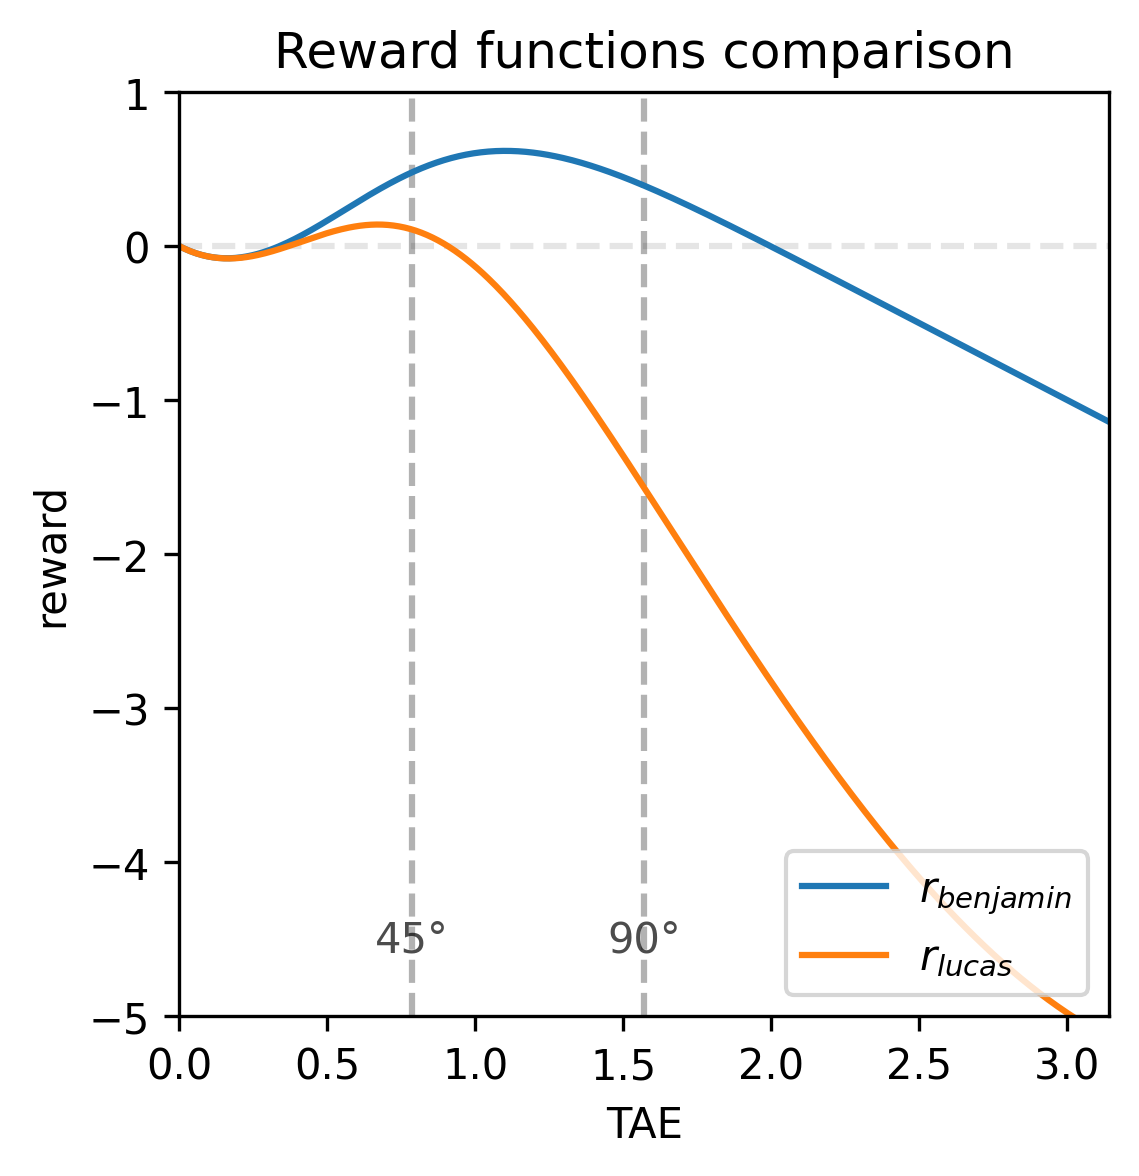

In [15]:
# fake polar
def v(theta, v_max=2):
    theta_no_go_zone = np.pi/4 # 45°
    return v_max * (1 - np.exp(-(theta/theta_no_go_zone)**2))

theta = np.linspace(0, 2*np.pi, 1000)

r_benjamin = -theta + v(theta)
r_lucas = -theta + v(theta)*np.cos(theta)

plt.subplots(figsize=(4, 4), dpi=300)

plt.xlim(0, np.pi)
plt.ylim(-5, 1)
plt.hlines(0, 0, np.pi, linestyles='--', colors='k', alpha=.1)
plt.vlines(np.pi/2, -5, 1, linestyles='--', colors='k', alpha=.3)
plt.text(np.pi/2, -4.5, '90°', ha='center', va='center', alpha=.7)
plt.vlines(np.pi/4, -5, 1, linestyles='--', colors='k', alpha=.3)
plt.text(np.pi/4, -4.5, '45°', ha='center', va='center', alpha=.7)
plt.plot(theta, r_benjamin, label='$r_{benjamin}$')
plt.plot(theta, r_lucas, label='$r_{lucas}$')
plt.xlabel('TAE')
plt.ylabel('reward')
plt.title('Reward functions comparison')
plt.legend(loc='lower right')

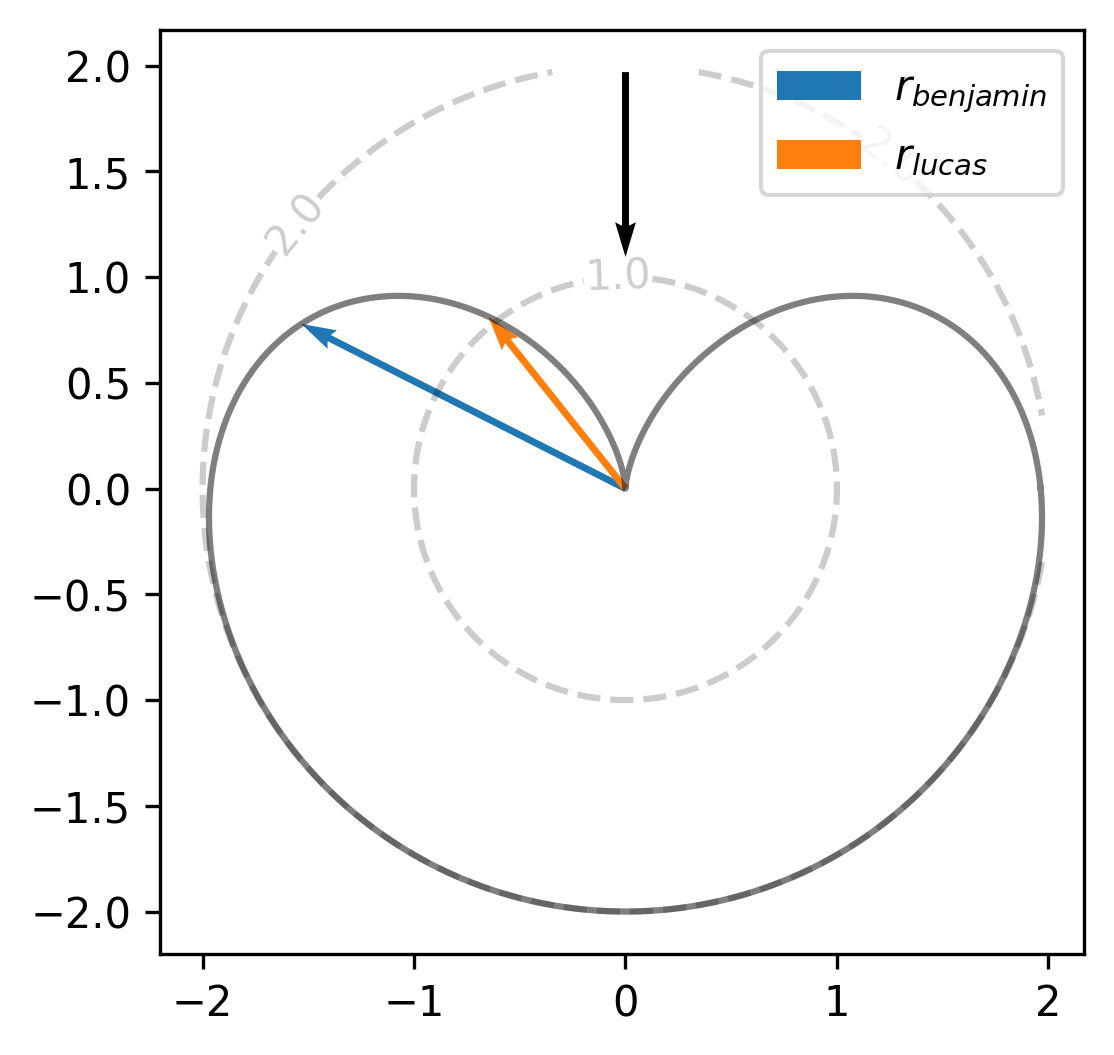

In [17]:
wind_theta = np.pi/2

plt.subplots(figsize=(4, 4), dpi=300)

d_theta = (theta - wind_theta) % (2*np.pi)
d_theta[d_theta > np.pi] = 2*np.pi - d_theta[d_theta > np.pi]
vmc = v(d_theta)

# VMC
init_coord = np.array([0, 0])
coords = init_coord + np.array([np.cos(theta), np.sin(theta)]).T * vmc[:, None] # meters to cm

# plot contour
def fmt(x):
    s = f'{x:.1f}'
    return rf'{s}' if plt.rcParams['text.usetex'] else f'{s}'

space = np.linspace(coords.min(), coords.max(), 100)
X, Y = np.meshgrid(space, space)
Z = (X**2 + Y**2)**0.5  # distance from origin
CS = plt.contour(X, Y, Z,
                levels=np.arange(0, Z.max(), 1), linestyles='dashed', colors='k', alpha=.2)
plt.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10)

# plot wind
wind_coords = np.array([np.cos(wind_theta), np.sin(wind_theta)])
x_mid =  (coords[:, 0].max() + coords[:, 0].min()) / 2
y_top = coords.max()
plt.quiver(x_mid, y_top, *-wind_coords, color='k', scale=5, zorder=10)

theta_benjamin = theta[r_benjamin.argmax()]
theta_lucas = theta[r_lucas.argmax()]

# plot best theta for each reward
plt.quiver(0, 0, np.cos(theta_benjamin+wind_theta)*v(theta_benjamin), np.sin(theta_benjamin+wind_theta)*v(theta_benjamin), angles='xy', scale_units='xy', scale=1, color='C0', label='$r_{benjamin}$')
plt.quiver(0, 0, np.cos(theta_lucas+wind_theta)*v(theta_lucas), np.sin(theta_lucas+wind_theta)*v(theta_lucas), angles='xy', scale_units='xy', scale=1, color='C1', label='$r_{lucas}$')

# plot polar
plt.plot(coords[:, 0], coords[:, 1], color='k', alpha=0.5)

plt.legend()
plt.xlim(coords.min()-.2, coords.max()+.2)
plt.ylim(coords.min()-.2, coords.max()+.2)
plt.gca().set_aspect('equal');

# Reward shaping

In [19]:
xte = np.linspace(0, 1, 100)
vmc = np.linspace(-1, 1, 100)
XTE, VMC = np.meshgrid(xte, vmc)

def sigmoid(x):
    return 1/(1 + np.exp(-x))

def sigmoid_bar(x):
    return 2*sigmoid(x) - 1

delta = .4

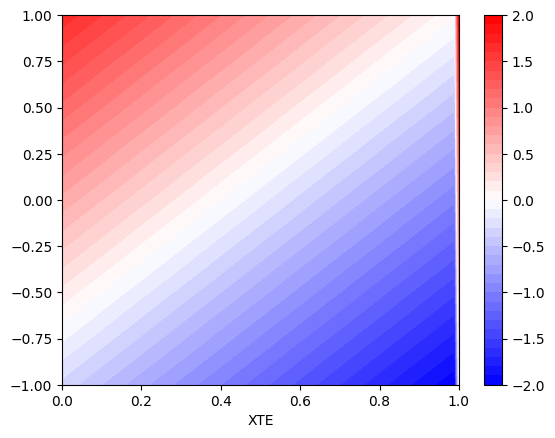

In [55]:
_XTE = XTE - delta
b = _XTE.max()
_XTE[np.abs(_XTE) >= b] = -b
_XTE /= b

Z = -_XTE + VMC
# Z = -_XTE

plt.xlabel('XTE')
# plt.ylabel('VMC')
plt.contourf(XTE, VMC, Z, levels=45, cmap='bwr')
plt.colorbar()

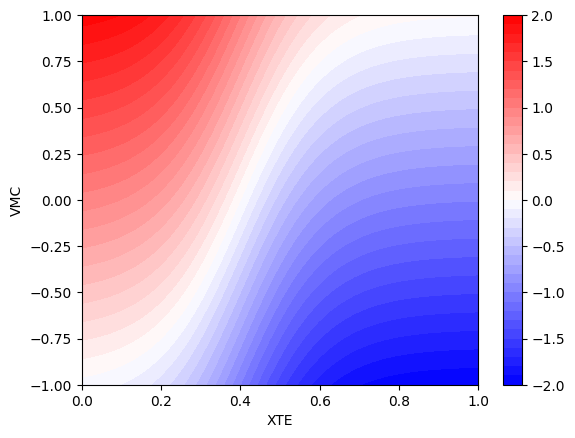

In [15]:
eps = .1
eta = .9

alpha = np.log((2+eta)/(2-eta))/eps
Z = sigmoid_bar(-alpha*(XTE - delta)) + VMC

plt.xlabel('XTE')
plt.ylabel('VMC')
plt.contourf(XTE, VMC, Z, levels=45, cmap='bwr')
plt.colorbar()

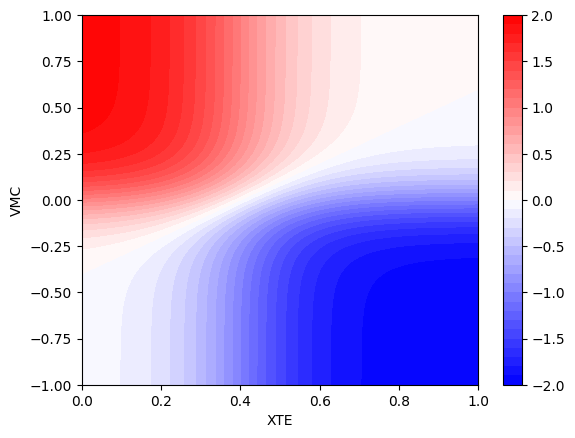

In [16]:
Z = sigmoid_bar(-alpha*(XTE - delta)) + sigmoid_bar(alpha*VMC)

plt.xlabel('XTE')
plt.ylabel('VMC')
plt.contourf(XTE, VMC, Z, levels=45, cmap='bwr')
plt.colorbar()
